# Data Preprocessing

The dataset contains passenger data for the titanic cruise including whether the passenger survived or not.

The data has a few minor issues:

1. missing values
   - Age, Cabin, and Embarked contain missing values
2. "incorrect" values
   - Fare contains some zero values, could be false data
3. Target classes not equally distributed (more 0s than 1s)
   - plays a role when training the model (bootstrapping 0.632 assumes equal distribution)

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

np.random.seed(42)

df = pd.read_csv('data/titanic.csv', index_col='PassengerId')
df.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

In [2]:
df.shape

(891, 11)

In [3]:
(df['Fare'] <= 0).sum()

15

Not sure whether the zero-fares are a mistake, removing them just in case since it's not that many

In [4]:
df = df[df['Fare'] > 0]
df.shape

(876, 11)

Only Age, Cabin and Embarked have nan values

In [5]:
df.isna().any()

Survived    False
Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool

In [6]:
df['Age'].isna().sum()

169

Since the Age column seems to contain quite a bit of nans, discarding these rows would result in a lot of lost data. Alternative option is to use the mean Age as a filler value:

In [7]:
df['Age'].fillna(df['Age'].mean(), inplace=True)
df

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
...               ...     ...   
887                 0       2   
888                 1       1   
889                 0       3   
890                 1       1   
891                 0       3   

                                                          Name     Sex  \
PassengerId                                                              
1                                      Braund, Mr. Owen Harris    male   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
3                                       Heikkinen, Miss. Laina  female   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
5                                     Allen, Mr. William Henry    male   
...                                                        ...     ...   
887                                      Montvila, Rev. Juozas    male   
888                               Graham, Miss. Margaret Edith  female   
889                   Johnston, Miss. Catherine Helen "Carrie"  female   
890                                      Behr, Mr. Karl Howell    male   
891                                        Dooley, Mr. Patrick    male   

                   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                                     
1            22.000000      1      0         A/5 21171   7.2500   NaN        S  
2            38.000000      1      0          PC 17599  71.2833   C85        C  
3            26.000000      0      0  STON/O2. 3101282   7.9250   NaN        S  
4            35.000000      1      0            113803  53.1000  C123        S  
5            35.000000      0      0            373450   8.0500   NaN        S  
...                ...    ...    ...               ...      ...   ...      ...  
887          27.000000      0      0            211536  13.0000   NaN        S  
888          19.000000      0      0            112053  30.0000   B42        S  
889          29.645219      1      2        W./C. 6607  23.4500   NaN        S  
890          26.000000      0      0            111369  30.0000  C148        C  
891          32.000000      0      0            370376   7.7500   NaN        Q  

[876 rows x 11 columns]

In [8]:
df['Cabin'].isna().sum()

675

In [9]:
df['Embarked'].isna().sum()

2

Embarked only has two samples and doesn't have a sensible "default" value, so we can discard those. The cabin number contains too many missing values, does not have a sensible default and won't be relevant for our models anyways, so we ignore that:

In [10]:
df.dropna(subset='Embarked', inplace=True)
df.shape

(874, 11)

Check the distribution of our outcome classes:

<Axes: ylabel='Frequency'>

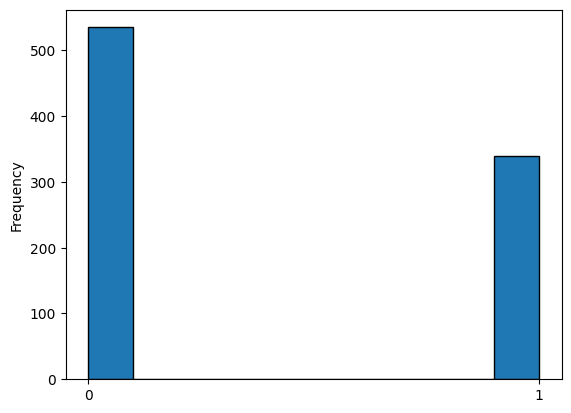

In [11]:
df['Survived'].plot(kind='hist', edgecolor='black', xticks= [0, 1])

Two options for encoding in this case: one-hot or ordinal. 

In this case, we keep the Pclass values since they are "ordered" (1 > 2 > 3).

For Embarked, we use one-hot encoding since they have no particular order:

In [12]:
#pclasses = pd.get_dummies(df['Pclass'], prefix='Pclass')
#df = pd.concat([df, pclasses], axis=1)
#df = df.drop('Pclass', axis=1)

In [13]:
embarked = pd.get_dummies(df['Embarked'], prefix='Embarked')
df = pd.concat([df, embarked], axis=1)
df = df.drop('Embarked', axis=1)
df.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin  Embarked_C  \
PassengerId                                                              
1                1      0         A/5 21171   7.2500   NaN       False   
2                1      0          PC 17599  71.2833   C85        True   
3                0      0  STON/O2. 3101282   7.9250   NaN       False   
4                1      0            113803  53.1000  C123       False   
5                0      0            373450   8.0500   NaN       False   

             Embarked_Q  Embarked_S  
PassengerId                          
1                 False        True  
2                 False       False  
3                 False        True  
4                 False        True  
5                 False        True

In [14]:
df = df.replace({False: 0, True: 1, 'male': 0, 'female': 1})
df.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name  Sex   Age  \
PassengerId                                                                 
1                                      Braund, Mr. Owen Harris    0  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0   
3                                       Heikkinen, Miss. Laina    1  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0   
5                                     Allen, Mr. William Henry    0  35.0   

             SibSp  Parch            Ticket     Fare Cabin  Embarked_C  \
PassengerId                                                              
1                1      0         A/5 21171   7.2500   NaN           0   
2                1      0          PC 17599  71.2833   C85           1   
3                0      0  STON/O2. 3101282   7.9250   NaN           0   
4                1      0            113803  53.1000  C123           0   
5                0      0            373450   8.0500   NaN           0   

             Embarked_Q  Embarked_S  
PassengerId                          
1                     0           1  
2                     0           0  
3                     0           1  
4                     0           1  
5                     0           1

Discard Name, Ticket, Cabin since in this case they are not relevant features:

In [15]:
feature_labels = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[feature_labels].isna().any().any()

False

Now, we create numpy arrays from the features and target classes. 

We transform the data using standardization for later use, since Logistic Regression and KNN will expect scaled data.

In [16]:
X = df[feature_labels].to_numpy()
y = df['Survived'].to_numpy()
X.shape, y.shape

((874, 9), (874,))

In [17]:
X

array([[ 3.        ,  0.        , 22.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        ,  1.        , 38.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 3.        ,  1.        , 26.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 3.        ,  1.        , 29.64521924, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        ,  0.        , 26.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 3.        ,  0.        , 32.        , ...,  0.        ,
         1.        ,  0.        ]])

In [18]:
X_scaled = scale(X)
X_scaled

array([[ 0.81788232, -0.74509069, -0.58289556, ..., -0.48781179,
        -0.31082519,  0.62410508],
       [-1.58087321,  1.34211849,  0.64447249, ...,  2.04997096,
        -0.31082519, -1.60229427],
       [ 0.81788232,  1.34211849, -0.27605355, ..., -0.48781179,
        -0.31082519,  0.62410508],
       ...,
       [ 0.81788232,  1.34211849,  0.00357306, ..., -0.48781179,
        -0.31082519,  0.62410508],
       [-1.58087321, -0.74509069, -0.27605355, ...,  2.04997096,
        -0.31082519, -1.60229427],
       [ 0.81788232, -0.74509069,  0.18420947, ..., -0.48781179,
         3.21724251, -1.60229427]])

Calculate the 0.632-bootstrap score for a given model and its inputs and outputs.

We use resample for our training data and our test data are the instances that are "left over" e.g. not contained in our resample.

We then get the error rate for our training and tests data for each iteration.

At the end, we use the mean of our training and test errors and calculate the bootstrap estimate using our equation:

$ e = 0.632 \cdot e_{test instances} + 0.368 \cdot e_{train instances} $

In [19]:
def get_bootstrap_score(model, X_m, y_m):
    num_bootstrap_samples = 1000
    e_trains = []
    e_tests = []
    
    for _ in range(num_bootstrap_samples):
        X_train, y_train = resample(X_m, y_m, replace=True, random_state=42)
        indices_not_selected = np.setdiff1d(np.arange(len(X_m)), np.unique(X_train, return_index=True)[1])
        X_test, y_test = X_m[indices_not_selected], y_m[indices_not_selected]

        model.fit(X_train, y_train)
        e_train = 1 - model.score(X_train, y_train)
        e_test = 1 - model.score(X_test, y_test)

        e_trains.append(e_train)
        e_tests.append(e_test)

    e_trains = np.array(e_trains)
    e_tests = np.array(e_tests)
    bootstrap_estimate = 0.368 * np.mean(e_trains) + 0.632 * np.mean(e_tests)
    
    print("0.632 Bootstrap Estimate:", bootstrap_estimate)
    return bootstrap_estimate

Our K-Fold cross validation is much simpler, we use the Scikit-Learn implementation and take 10 splits on our data.

Then we get the mean over all our scores.

In [20]:
def get_kfolds_score(model, X_m, y_m):
    kf = KFold(n_splits=10)
    kf_scores = []
    for train_index, test_index in kf.split(X_m):
        X_train, X_test = X_m[train_index], X_m[test_index]
        y_train, y_test = y_m[train_index], y_m[test_index]

        model.fit(X_train, y_train)
        kf_scores.append(1 - model.score(X_test, y_test))

    kf_scores = np.array(kf_scores)
    print("Average Cross-Validation Score:", np.mean(kf_scores))
    return np.mean(kf_scores)

Now, we can create our models and take a look at their scores

In [21]:
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)

b_scores = []
kf_scores = []

print(lr)
b_scores.append(get_bootstrap_score(lr, X_scaled, y))
kf_scores.append(get_kfolds_score(lr, X_scaled, y))

print(dt)
b_scores.append(get_bootstrap_score(dt, X, y))
kf_scores.append(get_kfolds_score(dt, X, y))

print(knn)
b_scores.append(get_bootstrap_score(knn, X_scaled, y))
kf_scores.append(get_kfolds_score(knn, X_scaled, y))

LogisticRegression(random_state=42)
0.632 Bootstrap Estimate: 0.19074935988620204
Average Cross-Validation Score: 0.20704022988505746
DecisionTreeClassifier(random_state=42)
0.632 Bootstrap Estimate: 0.07141704655339132
Average Cross-Validation Score: 0.21387147335423196
KNeighborsClassifier(n_neighbors=3)
0.632 Bootstrap Estimate: 0.12135021337126603
Average Cross-Validation Score: 0.19899425287356323


In [22]:
df_scores = pd.DataFrame(
    {'name': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbor'], 'Bootstrapping Score': b_scores, 'KFold Score': kf_scores}
)
px.bar(df_scores, x='name', y=['Bootstrapping Score', 'KFold Score'], barmode='group')

We can also calculate the kappa scores using $ (p-r) / (1 - r)$ as well as create confusion matrices for our models:

In [23]:
kappa_scores = []

y_pred_lr = lr.predict(X_scaled)
kappa_scores.append(cohen_kappa_score(y, y_pred_lr))
cm_lr = confusion_matrix(y, y_pred_lr)

y_pred_dt = dt.predict(X)
kappa_scores.append(cohen_kappa_score(y, y_pred_dt))
cm_dt = confusion_matrix(y, y_pred_dt)

y_pred_knn = knn.predict(X_scaled)
kappa_scores.append(cohen_kappa_score(y, y_pred_knn))
cm_knn = confusion_matrix(y, y_pred_knn)

class_labels = ['Didn\'t Survive', 'Survived']

fig = make_subplots(rows=1, cols=3, subplot_titles=["Logistic Regression", "Decision Tree", "K-Nearest Neighbor"])
fig.add_trace(go.Heatmap(z=cm_lr, x=class_labels, y=class_labels, colorscale="Viridis", coloraxis="coloraxis"), row=1, col=1)
fig.add_trace(go.Heatmap(z=cm_dt, x=class_labels, y=class_labels, colorscale="Viridis", coloraxis="coloraxis"), row=1, col=2)
fig.add_trace(go.Heatmap(z=cm_knn, x=class_labels, y=class_labels, colorscale="Viridis", coloraxis="coloraxis"), row=1, col=3)

fig.update_layout(
    title_text="Confusion Matrices",
    xaxis=dict(title="Predicted Class"),
    yaxis=dict(title="True Class"),
    coloraxis1=dict(colorscale="Blues")
)

fig.show()

In [24]:
df_scores = pd.DataFrame(
    {'name': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbor'], 'Kappa Score': kappa_scores}
)
px.bar(df_scores, x='name', y=['Kappa Score'])

If we want additional statistics like precision, recall and F1 score, we can use the classification report:

In [25]:
print(classification_report(y, y_pred_lr, target_names=class_labels))

                precision    recall  f1-score   support

Didn't Survive       0.83      0.86      0.84       535
      Survived       0.76      0.72      0.74       339

      accuracy                           0.80       874
     macro avg       0.79      0.79      0.79       874
  weighted avg       0.80      0.80      0.80       874



And we can plot the classification reports for all of our models

In [26]:
y_preds = [y_pred_lr, y_pred_dt, y_pred_knn]
names = ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors']
classes = class_labels

df = pd.DataFrame()
for i in range(0, 3):
    report = classification_report(y, y_preds[i], target_names=class_labels, output_dict=True)
    
    # Extract metrics for each class
    precision = [report[class_name]['precision'] for class_name in classes]
    recall = [report[class_name]['recall'] for class_name in classes]
    f1_score = [report[class_name]['f1-score'] for class_name in classes]
    # Create a DataFrame for each model and metric
    model_df = pd.DataFrame({
        'Class': classes * 3,
        'Metric': ['Precision'] * len(classes) + ['Recall'] * len(classes) + ['F1-Score'] * len(classes),
        'Score': precision + recall + f1_score,
        'Model': [names[i]] * (3 * len(classes))
    })
    
    # Concatenate the DataFrames
    df = pd.concat([df, model_df], ignore_index=True)
    
# Create an interactive bar chart
fig = px.bar(df, x='Class', y='Score', color='Metric', facet_col='Model',
             color_discrete_map={'Precision': 'blue', 'Recall': 'green', 'F1-Score': 'orange'},
             labels={'Score': 'Score', 'variable': 'Metric', 'x': 'Class'},
             title='Interactive Model Performance by Class',
             barmode='group')

# Update layout to improve readability
fig.update_layout(yaxis_title='Score', xaxis_title='Class')

Finally, we can take a look at the structure of our decision tree. In this case, we show the first four levels since showing the entire tree would be difficult in a Notebook:

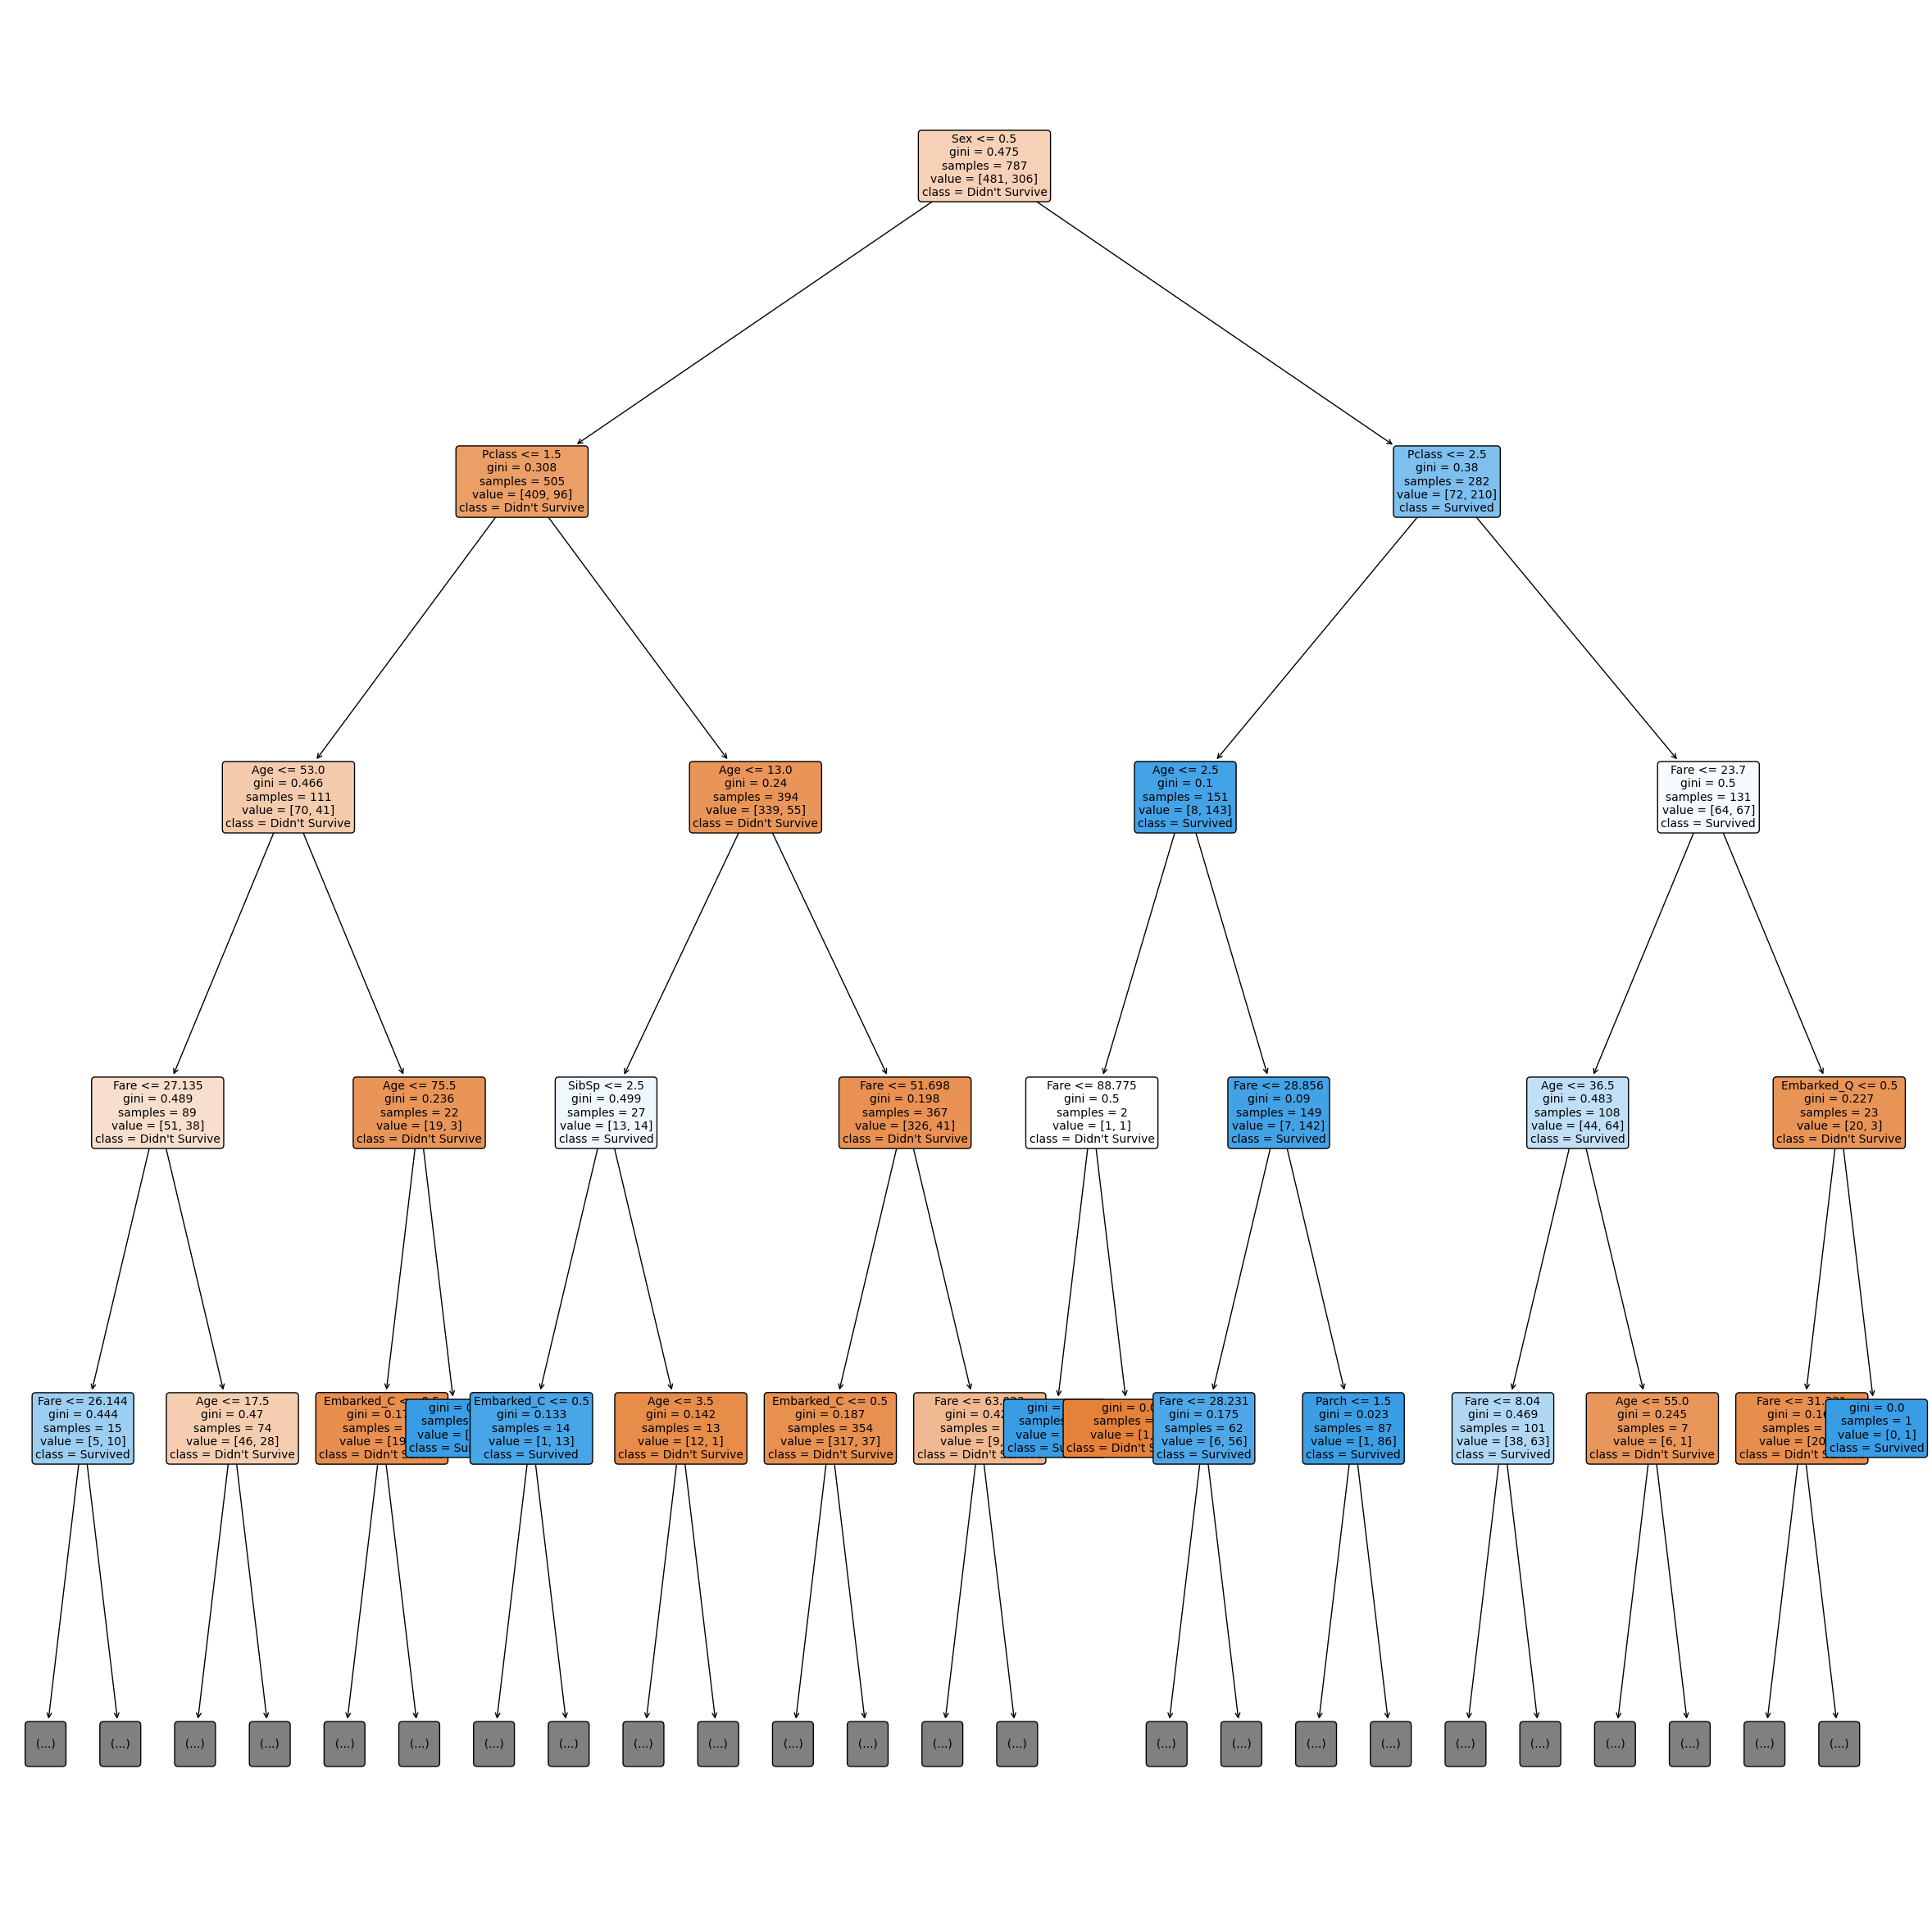

In [27]:
from sklearn import tree
fig = plt.figure(figsize=(30,30))
_ = tree.plot_tree(dt, 
                   feature_names=feature_labels,  
                   class_names=class_labels,
                   fontsize=10,
                   max_depth=4,
                   rounded=True,
                   filled=True)